### Importando bibliotecas e definindo hiperparâmetros para DataViz

In [1]:
from src.preprocessing import final_df
from src.models_functions import ts_pipeline, ml_pipeline, custom_train_test, lstm, prophet_predict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import rcParams
import warnings

# Remove Warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
# Parâmetros de Plotagem
# Tamanho da Figura
rcParams["figure.figsize"] = 18, 6

# Regras de formatação MBA USP/Esalq
# Fonte Arial, cor preta e tamanho máximo 11
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = 'black'

# Remover linhas de grade
rcParams['axes.grid'] = False

### Leitura, Tratamento e Exploração Inicial do Dataset

In [3]:
# Selecionar a ação

stock = 'bbas3'
stock = stock.upper()

In [4]:
# Criar Objetos DataFrame e Series e separar em treino e teste para os modelos futuros.

df = final_df(stock)

series = pd.Series(df[f"Close {stock}"])

y_train, y_test = custom_train_test(series)

In [5]:
df.head()

,Close BBAS3,Volume BBAS3,SELIC,IPCA,Cambio,Lag 1,Lag 3,Lag 5,ma_5d,ma_10d,ma_20d
Date,,,,,,,,,,,
2017-01-02,8.390503,3936400,0.1375,0.05354,3.2723,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,8.774381,15157800,0.1375,0.05354,3.2626,8.390503,NaN,NaN,NaN,NaN,NaN
2017-01-04,8.728682,8312600,0.1375,0.05354,3.2327,8.774381,NaN,NaN,NaN,NaN,NaN
2017-01-05,8.707357,10914200,0.1375,0.05354,3.2123,8.728682,8.390503,NaN,NaN,NaN,NaN
2017-01-06,8.801803,7384800,0.1375,0.05354,3.2051,8.707357,8.774381,NaN,8.680545,NaN,NaN


In [6]:
# Dataset Original

original_columns = [f"Close {stock}", f"Volume {stock}", "SELIC", "IPCA", "Cambio"]
df_original = df[original_columns]

In [7]:
# Info do Dataset

df_original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 2017-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close BBAS3   1992 non-null   float64
 1   Volume BBAS3  1992 non-null   int64  
 2   SELIC         1986 non-null   float64
 3   IPCA          1992 non-null   float64
 4   Cambio        1986 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 93.4 KB


In [8]:
df_original.describe()

,Close BBAS3,Volume BBAS3,SELIC,IPCA,Cambio
count,1992.000000,1.992000e+03,1986.000000,1992.000000,1986.000000
mean,15.555646,2.546404e+07,0.083883,0.050783,4.612771
std,5.450307,1.543343e+07,0.038410,0.025633,0.860030
min,7.841301,0.000000e+00,0.020000,0.018775,3.050400
25%,11.316624,1.563905e+07,0.056250,0.033030,3.843025
50%,14.047866,2.162840e+07,0.077500,0.044247,4.958250
75%,17.829995,3.076975e+07,0.117500,0.055963,5.293375
max,28.325697,2.040722e+08,0.137500,0.121315,6.198500


In [9]:
# Os dados tem valores faltantes em SELIC e Câmbio. Além disso, alguns dias tem volume negociado como 0. Verificar.

df_nulos = df_original[df_original.isnull().any(axis=1)]
df_nulos

# São as mesmas 6 linhas, que também tem volumes negociados como 0.

,Close BBAS3,Volume BBAS3,SELIC,IPCA,Cambio
Date,,,,,
2017-06-15,8.451182,0,NaN,0.029984,NaN
2017-09-07,10.175544,0,NaN,0.025377,NaN
2017-10-12,11.643029,0,NaN,0.027013,NaN
2017-11-02,10.584572,0,NaN,0.028039,NaN
2017-11-15,9.526115,0,NaN,0.028039,NaN
2017-12-25,9.836558,0,NaN,0.029473,NaN


In [10]:
# Solução: Substituir os valores inválidos (0) como null e depois aplicar a função forward fill: ffill()
df[f'Volume {stock}'] = df[f'Volume {stock}'].replace(0, np.nan)


In [11]:
df

,Close BBAS3,Volume BBAS3,SELIC,IPCA,Cambio,Lag 1,Lag 3,Lag 5,ma_5d,ma_10d,ma_20d
Date,,,,,,,,,,,
2017-01-02,8.390503,3936400.0,0.1375,0.053540,3.2723,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,8.774381,15157800.0,0.1375,0.053540,3.2626,8.390503,NaN,NaN,NaN,NaN,NaN
2017-01-04,8.728682,8312600.0,0.1375,0.053540,3.2327,8.774381,NaN,NaN,NaN,NaN,NaN
2017-01-05,8.707357,10914200.0,0.1375,0.053540,3.2123,8.728682,8.390503,NaN,NaN,NaN,NaN
2017-01-06,8.801803,7384800.0,0.1375,0.053540,3.2051,8.707357,8.774381,NaN,8.680545,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,24.080000,49200400.0,0.1225,0.048313,6.0774,23.889999,24.420000,24.510000,24.058000,24.398902,24.623714
2024-12-23,23.920000,12708100.0,0.1225,0.048313,6.1606,24.080000,23.740000,24.160000,24.010000,24.341071,24.565171
2024-12-26,24.200001,15208900.0,0.1225,0.048313,6.1650,23.920000,23.889999,24.420000,23.966000,24.295351,24.500604


In [12]:
df[[f'Volume {stock}', 'SELIC', 'Cambio']] = df[[f'Volume {stock}', 'SELIC', 'Cambio']].fillna(method='ffill')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 2017-01-02 to 2024-12-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close BBAS3   1992 non-null   float64
 1   Volume BBAS3  1992 non-null   float64
 2   SELIC         1992 non-null   float64
 3   IPCA          1992 non-null   float64
 4   Cambio        1992 non-null   float64
 5   Lag 1         1991 non-null   float64
 6   Lag 3         1989 non-null   float64
 7   Lag 5         1987 non-null   float64
 8   ma_5d         1988 non-null   float64
 9   ma_10d        1983 non-null   float64
 10  ma_20d        1973 non-null   float64
dtypes: float64(11)
memory usage: 186.8 KB


In [14]:
df_original = df[original_columns]

In [15]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 2017-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close BBAS3   1992 non-null   float64
 1   Volume BBAS3  1992 non-null   float64
 2   SELIC         1992 non-null   float64
 3   IPCA          1992 non-null   float64
 4   Cambio        1992 non-null   float64
dtypes: float64(5)
memory usage: 93.4 KB


### Exploração das Séries Tratadas

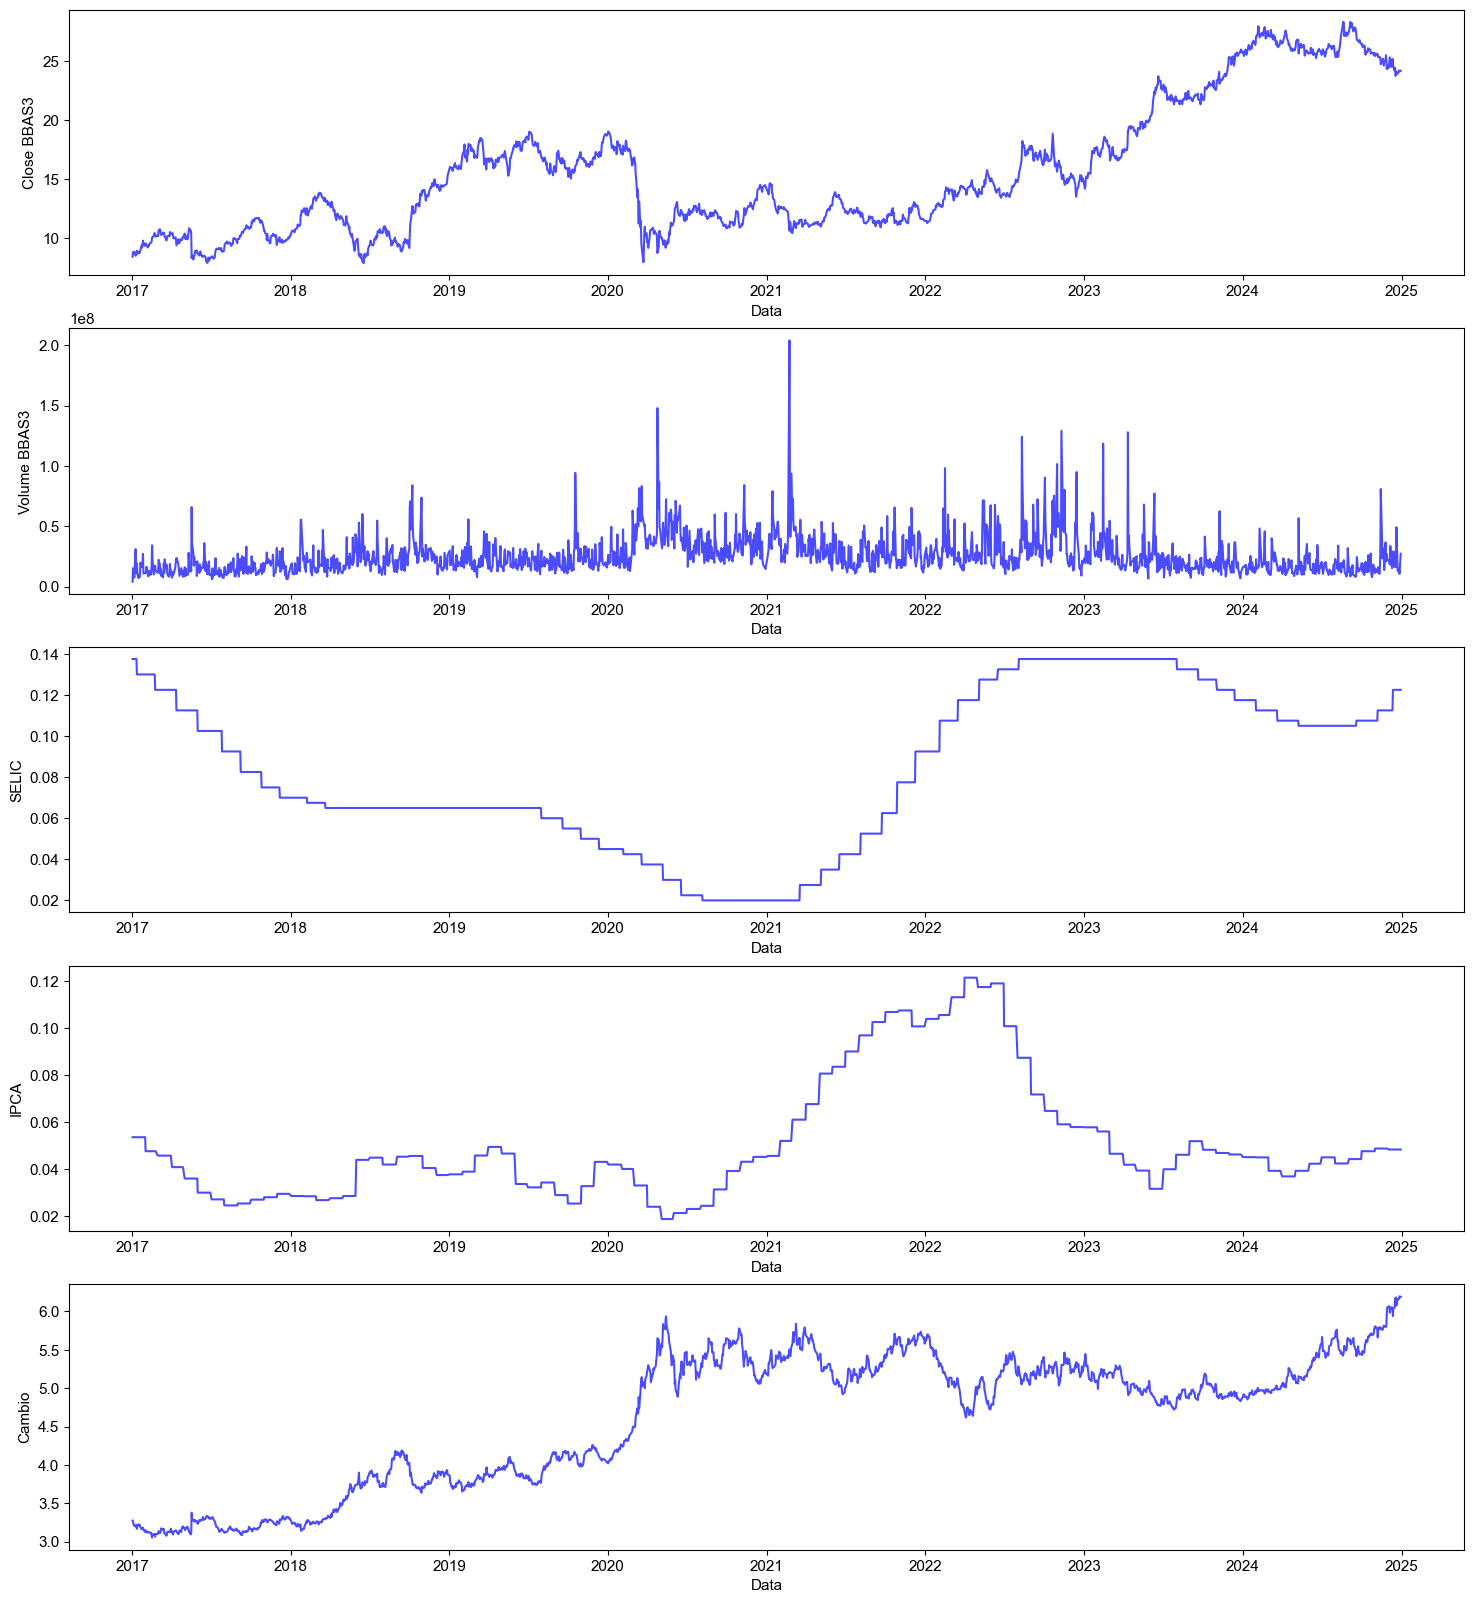

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 4*5))
for i, col in enumerate(df_original.columns):
    ax = axes[i]
    ax.plot(df.index, df_original[col], color='blue', alpha=0.7)
    ax.set_xlabel("Data")
    ax.set_ylabel(col)
    plt.title

In [34]:
df[original_columns].describe().round(4)

,Close BBAS3,Volume BBAS3,SELIC,IPCA,Cambio
count,1992.0000,1.992000e+03,1992.0000,1992.0000,1992.0000
mean,15.5556,2.562007e+07,0.0839,0.0508,4.6086
std,5.4503,1.536242e+07,0.0384,0.0256,0.8620
min,7.8413,3.936400e+06,0.0200,0.0188,3.0504
25%,11.3166,1.580940e+07,0.0600,0.0330,3.8349
50%,14.0479,2.167390e+07,0.0775,0.0442,4.9560
75%,17.8300,3.078500e+07,0.1175,0.0560,5.2927
max,28.3257,2.040722e+08,0.1375,0.1213,6.1985


<Axes: >

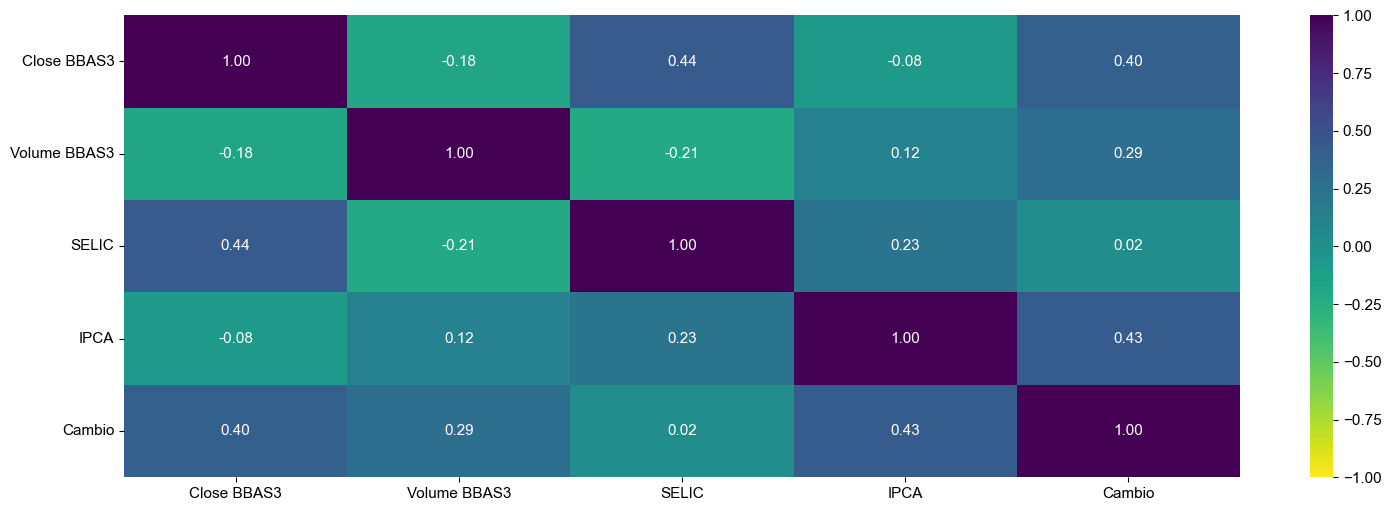

In [18]:
sns.heatmap(df[original_columns].corr(), vmin=-1, vmax=1, cmap="viridis_r", annot=True, fmt='.2f')

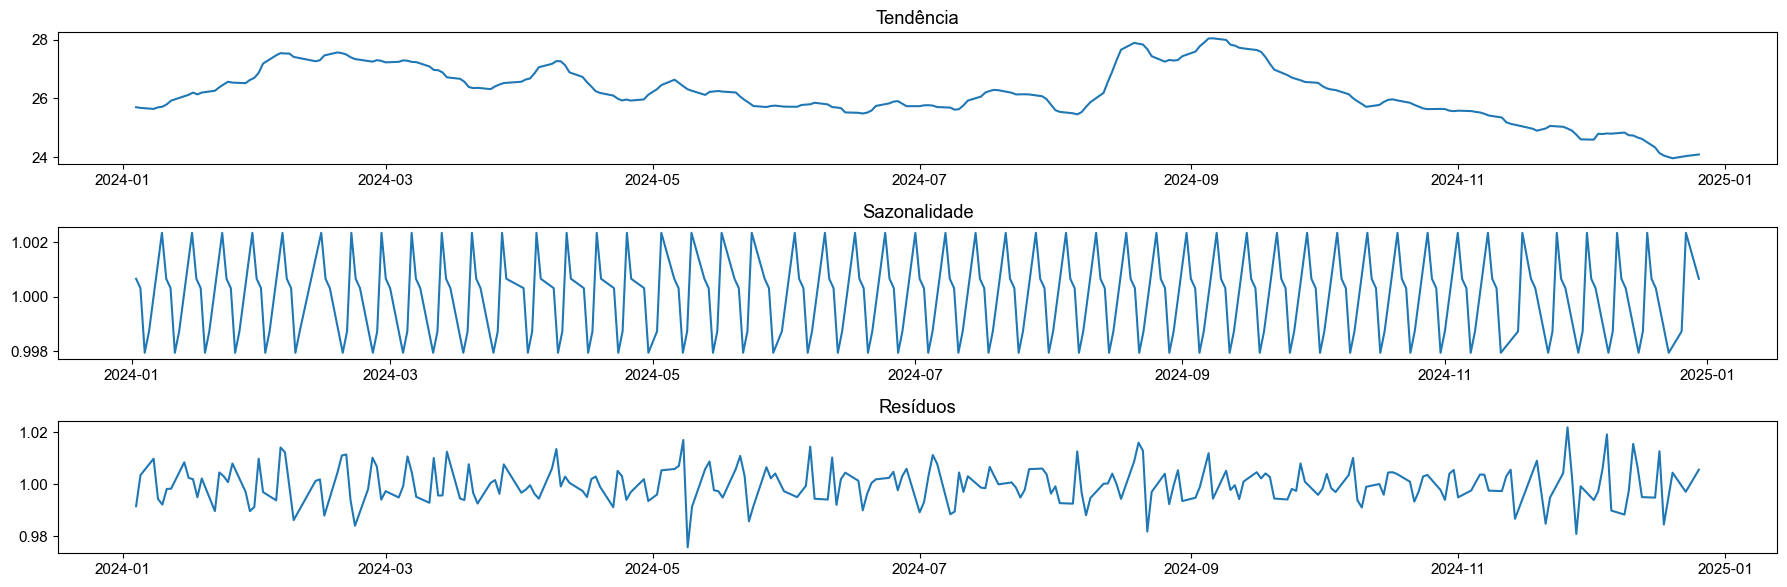

In [19]:
# Decomposição da série Temporal em seus componentes (Tendência, Sazonal e Resíduos)

decompa = seasonal_decompose(series[series.index.year >= 2024], model="multiplicative", period=5)

plt.subplot(3, 1, 1)
plt.plot(decompa.trend)
plt.title("Tendência")

plt.subplot(3, 1, 2)
plt.plot(decompa.seasonal)
plt.title("Sazonalidade")

plt.subplot(3, 1, 3)
plt.plot(decompa.resid)
plt.title("Resíduos")

plt.tight_layout()
plt.show()

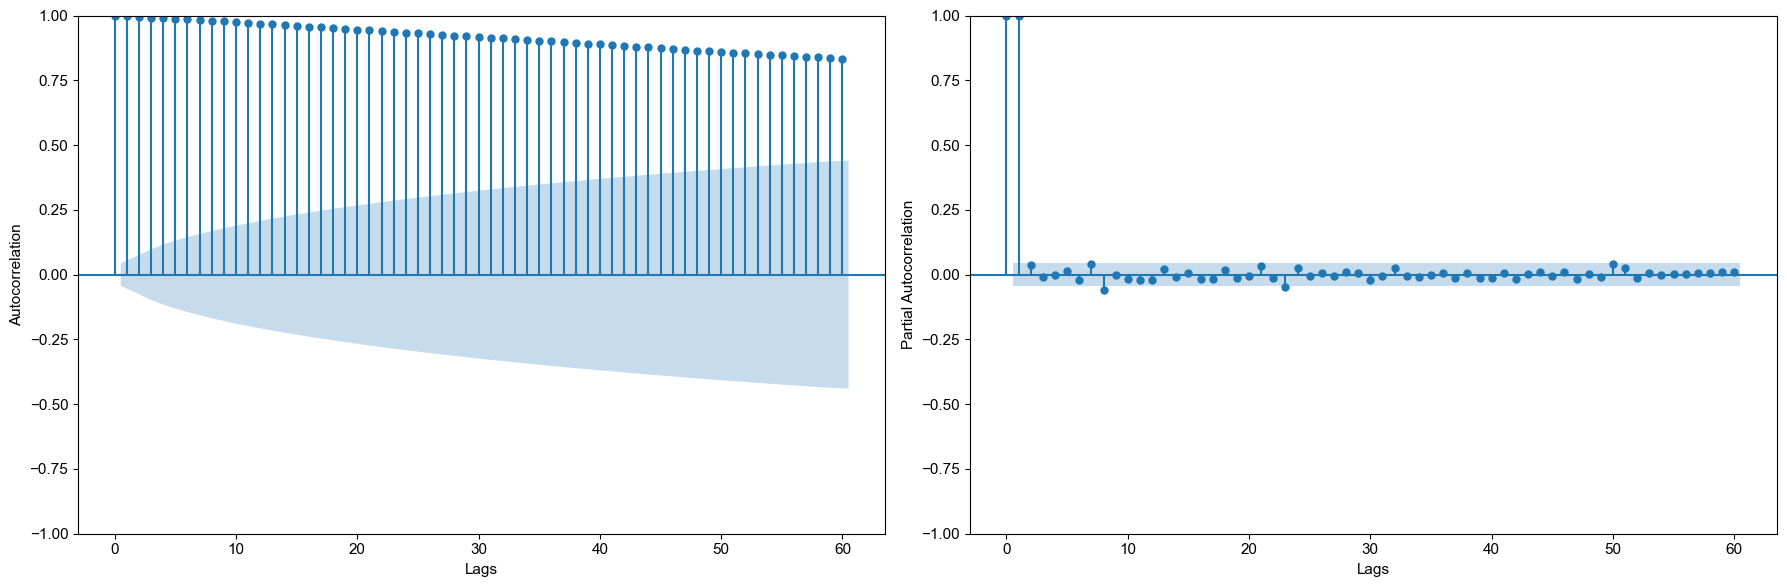

In [35]:
# ACF e PACF
fig, axes = plt.subplots(nrows=1, ncols=2)

plot_acf(series, ax=axes[0], lags=60)
axes[0].set_ylabel("Autocorrelation")
axes[0].set_xlabel("Lags")
axes[0].set_title("")
plot_pacf(series, ax=axes[1], lags=60)
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].set_xlabel("Lags")
axes[1].set_title("")
plt.tight_layout()
plt.show()

### Modelagem Preditiva

In [21]:
ts_results = ts_pipeline(series)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=961.022, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=972.063, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=969.129, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=969.225, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=971.725, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=968.412, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=973.004, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=963.008, Time=2.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=963.006, Time=2.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=971.068, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=966.702, Time=1.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=965.558, Time=1.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=964.912, Time=2.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=960.805, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=968.2

In [22]:
prophet_dict = prophet_predict(series)

11:34:20 - cmdstanpy - INFO - Chain [1] start processing
11:34:21 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
ml_results = ml_pipeline(df, stock)

Treinando DecisionTree...
Treinando RandomForest...
Treinando XGBoost...
Treinando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 1865, number of used features: 10
[LightGBM] [Info] Start training from score 14.846001


In [24]:
lstm_dict = lstm(df, stock)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1177 - val_loss: 0.2284
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - val_loss: 0.0845
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0499
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0216
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 4.3580e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7552e-04 - val_loss: 3.0718e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2310e-04 - val_loss: 4.3722e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3090e-04 - val_loss: 5.0500e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2930e-04 - val_loss: 4.8160e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1594e-04 - val_loss: 4.7997e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━

In [25]:
neat_models_info = []

neat_models_info.append({
    "Nome do Modelo": lstm_dict["nome"],
    "Previsão": lstm_dict["predict"],
    "MAPE - Base de Teste": lstm_dict["mape_test"]
})

neat_models_info.append({
    "Nome do Modelo": prophet_dict["nome"],
    "Previsão": prophet_dict["predict"],
    "MAPE - Base de Teste": prophet_dict["mape_test"]
})

for model_name, model_info in ml_results.items():
    neat_models_info.append({
        "Nome do Modelo": model_name,
        "Previsão": model_info["predict"],
        "MAPE - Base de Teste": model_info["mape_test"]
    })

for _, row in ts_results.iterrows():
    neat_models_info.append({
        "Nome do Modelo": row["Nome do Modelo"],
        "Previsão": row["Previsão"],
        "MAPE - Base de Teste": row["MAPE"]
    })


In [26]:
neat_models_df = pd.DataFrame(neat_models_info)

In [27]:
neat_models_df["Previsão"] = neat_models_df["Previsão"].apply(lambda x: np.array(x).reshape(-1))

In [28]:
neat_models_df = neat_models_df.sort_values(by="MAPE - Base de Teste", ascending=True)

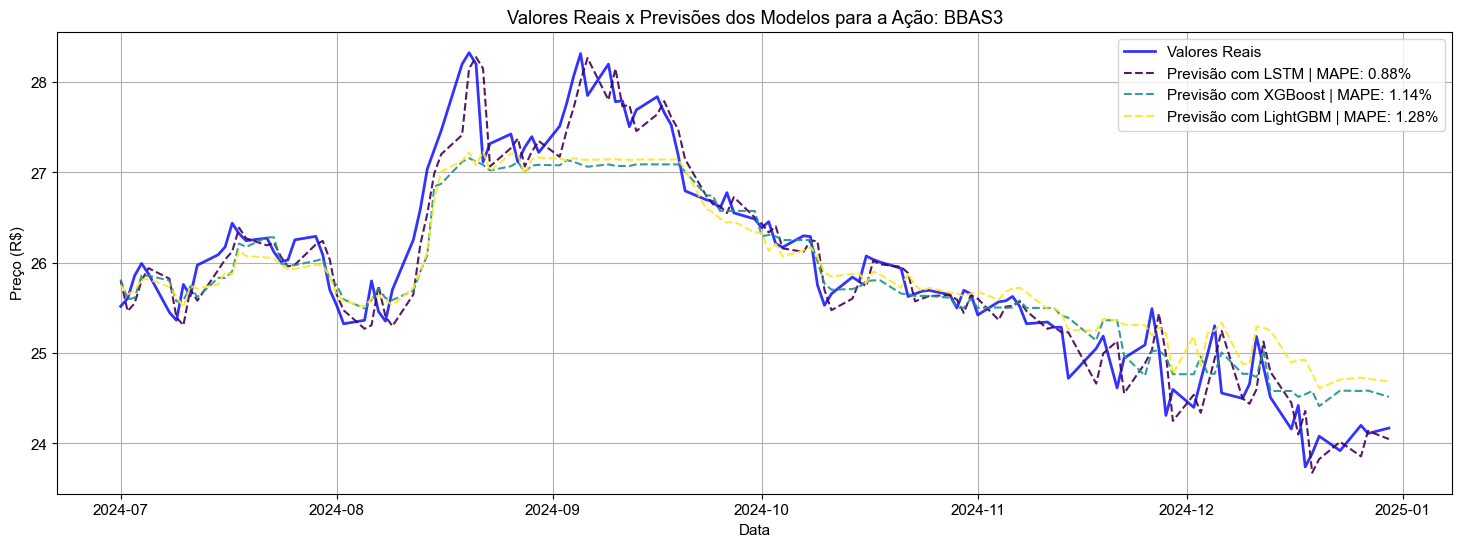

In [29]:
# Plotando as previsões dos top n modelos

top_n = 3  # Configurar parâmetro

plt.plot(y_test.index, y_test, label="Valores Reais", linewidth=2, color='blue', alpha=0.8)
colors = cm.viridis(np.linspace(0, 1, top_n))

for i, (_, row) in enumerate(neat_models_df[:top_n].iterrows()):
    nome_modelo = row["Nome do Modelo"]
    previsao = row["Previsão"]
    plt.plot(y_test.index, previsao, label=f'Previsão com {nome_modelo} | MAPE: {row["MAPE - Base de Teste"] * 100:.2f}%', linestyle='--', color=colors[i], alpha=0.9)

plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.title(f"Valores Reais x Previsões dos Modelos para a Ação: {stock}")
plt.legend()
plt.grid()
plt.show()

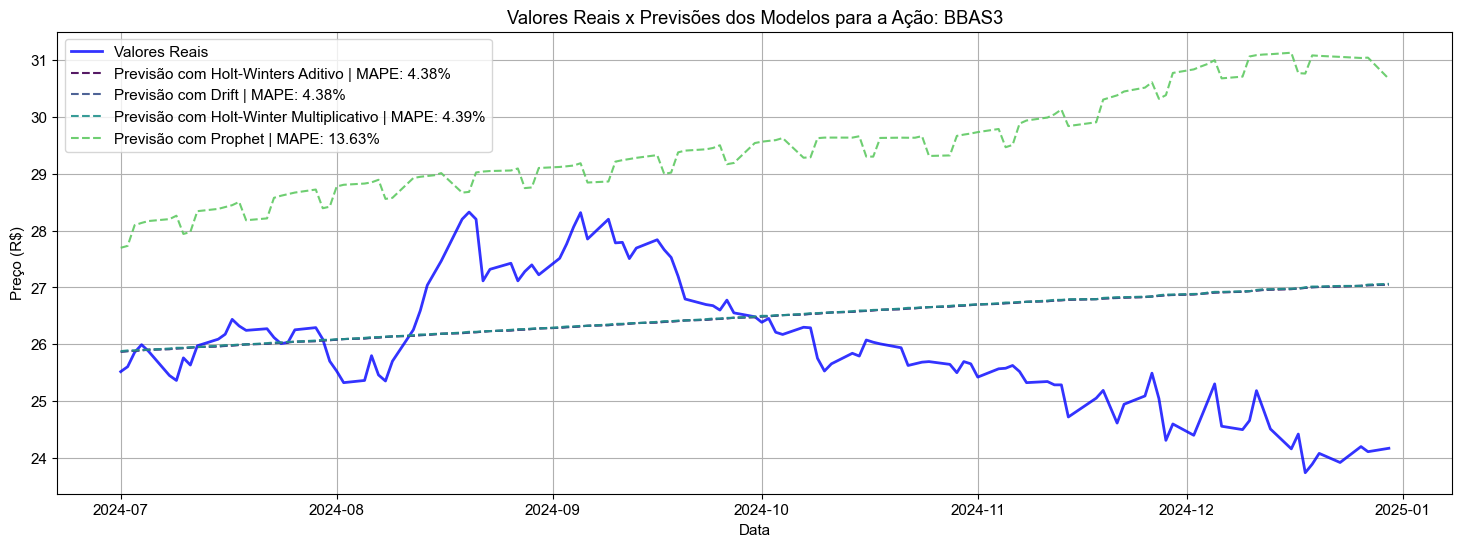

In [30]:
# Plotando as previsões dos bottom n modelos

top_n = 5  # Configurar parâmetro
bottom_n = -top_n

plt.plot(y_test.index, y_test, label="Valores Reais", linewidth=2, color='blue', alpha=0.8)
colors = cm.viridis(np.linspace(0, 1, top_n))

for i, (_, row) in enumerate(neat_models_df[bottom_n:-1].iterrows()):
    nome_modelo = row["Nome do Modelo"]
    previsao = row["Previsão"]
    plt.plot(y_test.index, previsao, label=f'Previsão com {nome_modelo} | MAPE: {row["MAPE - Base de Teste"] * 100:.2f}%', linestyle='--', color=colors[i], alpha=0.9)

plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.title(f"Valores Reais x Previsões dos Modelos para a Ação: {stock}")
plt.legend()
plt.grid()
plt.show()

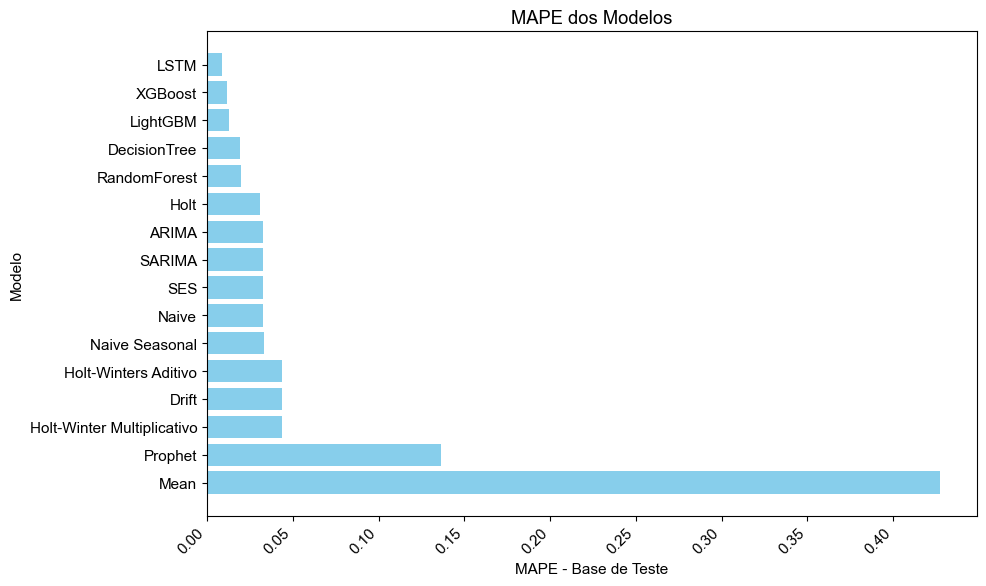

In [31]:
# Plotando os MAPES

plt.figure(figsize=(10,6))
plt.barh(neat_models_df["Nome do Modelo"], neat_models_df["MAPE - Base de Teste"], color='skyblue')

plt.xlabel("MAPE - Base de Teste")
plt.ylabel("Modelo")
plt.title("MAPE dos Modelos")
plt.xticks(rotation=45, ha='right')  # gira os nomes para melhor leitura
plt.gca().invert_yaxis()
plt.tight_layout()